# Interpolators with "decay" in HARK

## Preliminaries

Suppose we have an interpolator $f(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$, and some limiting function $g(\cdot): \mathbb{R}^n\rightarrow \mathbb{R}$.

We want to construct some enhanced function $h(\cdot):\mathbb{R}^n\rightarrow \mathbb{R}$ such that:
- $h(x) = f(x)$ when $x$ falls inside of the limits of $f$s grids.
- $h(x)\rightarrow g(x)$ when $x\rightarrow\infty$ in any of its dimensions.

We might want to construct such functions if we are worried about the performance of our interpolator $f(\cdot)$ when approximating values that fall far-off its grid. As demonstrated in Section 5.10 of ["Solution Methods for Microeconomic Dynamic Stochastic Optimization Problems"](https://llorracc.github.io/SolvingMicroDSOPs/) this situation arises when approximating the solution of consumption-saving problems: extrapolated solutions can have characteristics that are at odds with the basic theoretical properties of our problems. Fortunately, it is often possible to analytically solve the limiting version of these problems---for instance a version of a consumption-saving problem where wealth is infinitely larger than income---and to use these analytical solutions $g(\cdot)$ to moderate the extrapolating behavior of our numerical solutions.

This notebook exemplifies the use of HARK's `econforgeinterp.DecayInterp` class, which implements n-dimensional interpolators that assymptotically approach a given analytical function off their grids.



For any $x\in \mathbb{R}^n$ denote with $\bar{x}$ the closest point to $x$ which falls inside of $f's$ grid.

## Decay

For $x$ inside the grid we will just use $f(x)$. Now consider $x$'s such that $x \geq \bar{x}$.

We want to take an $h$ of the following form
\begin{equation}
    h(x) = g(x) - \left[g\left(\bar{x}\right) - f\left(\bar{x}\right)\right]\times\exp\{-B(x)\cdot(x - \bar{x})\}
\end{equation}

The weights $B(x)$ control how fast $h(\cdot)$ converges to $g(\cdot)$.

### Weights

Consider the weights
\begin{equation*}
B(x) = -\frac{1}{g\left(\bar{x}\right) - f\left(\bar{x}\right)}\times \left[ \nabla g\left(\bar{x}\right) - \nabla f\left(\bar{x}\right)\right].
\end{equation*}

They make $h(x)$ approach $g(x)$ faster when:
- $f$ and $g$ were close at the edge of the grid to begin with.
- $f$ and $g$ 's slopes suggest that they were approaching rapidly at the edge of the grid.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from HARK.econforgeinterp import LinearFast, DecayInterp
from HARK.interpolation import LinearInterp

# Some 2D tests

C:\GitHub\HARK\HARK\econforgeinterp.py:270: RuntimeWarning: divide by zero encountered in true_divide
  B = np.abs(np.divide(1, A) * (g_grad - f_grad))
C:\GitHub\HARK\HARK\econforgeinterp.py:270: RuntimeWarning: invalid value encountered in multiply
  B = np.abs(np.divide(1, A) * (g_grad - f_grad))


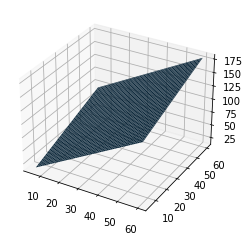

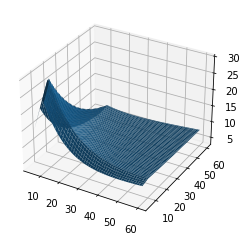

In [2]:
# Set up a bilinear extrapolator for a simple function
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)
x_t, y_t = np.meshgrid(x, y, indexing="ij")
z = 2 * x_t + y_t

# Base interpolator
interp = LinearFast(z, [x, y], extrap_mode="linear")

# An extrapolator that limits to the same function
interp_same = DecayInterp(
    interp,
    limit_fun=lambda x, y: 2 * x + y,
    limit_grad=lambda x, y: [np.ones_like(x) * 2, np.ones_like(y) * 1],
    extrap_method="decay_hark",    
)

# another that limits to a shifted function with different slopes
interp_shift = DecayInterp(
    interp,
    limit_fun=lambda x, y: np.sqrt(x),
    limit_grad=lambda x, y: [0.5 * np.power(x, -0.5), np.zeros_like(y)],
    extrap_method="decay_hark",    
)

x = np.linspace(5, 60, 100)
y = np.linspace(5, 60, 100)
x_t, y_t = np.meshgrid(x, y, indexing="ij")

z_same = interp_same(x_t, y_t)
z_shift = interp_shift(x_t, y_t)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_t, y_t, z_same)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_t, y_t, z_shift)
plt.show()

# Comparison with base HARK

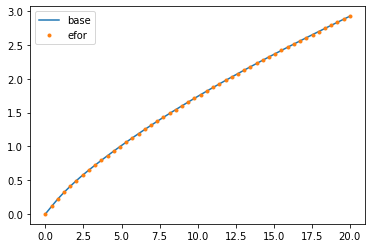

In [3]:
# Compare with base HARK
lim_slope = 0.1
lim_inter = 1.0

# Irregular grid
x = np.sqrt(np.linspace(0, 10, 20))
y = lim_inter + lim_slope * x - 1 / (0.2 * x + 1)

# Hark's base implementation
base_lim_interp = LinearInterp(
    x, y, intercept_limit=lim_inter, slope_limit=lim_slope
)

# New implementation
efor_lim_interp = DecayInterp(
    LinearFast(y, [x]),
    limit_fun=lambda x: lim_inter + lim_slope * x,
    limit_grad=lambda x: [lim_slope * np.ones_like(x)],
    extrap_method="decay_hark",    
)

# Evaluate them
x_eval = np.linspace(0, 20, 50)
base_vals = base_lim_interp(x_eval)
efor_vals = efor_lim_interp(x_eval)

# Plot and compare
plt.figure()
plt.plot(x_eval, base_vals, label="base")
plt.plot(x_eval, efor_vals, '.', label="efor")
plt.legend()
plt.show()

# Compare different "decay methods"

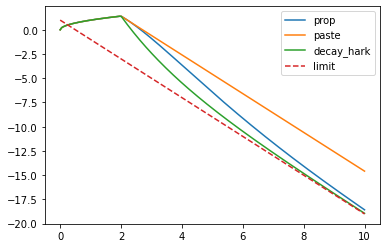

In [4]:
# Compare decay methods

x = np.linspace(0, 2, 50)
interp = LinearFast(np.sqrt(x), [x])
limit_fun = lambda x: 1 + -2 * x
limit_grad = lambda x: [-2 * np.ones_like(x)]

dec_pr = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_prop",    
)

dec_pa = DecayInterp(
    interp, limit_fun=limit_fun, limit_grad=limit_grad, extrap_method="paste",
)

dec_ha = DecayInterp(
    interp,
    limit_fun=limit_fun,
    limit_grad=limit_grad,
    extrap_method="decay_hark",   
)

x_ev = np.linspace(0, 10, 200)

plt.figure()
plt.plot(x_ev, dec_pr(x_ev), label="prop")
plt.plot(x_ev, dec_pa(x_ev), label="paste")
plt.plot(x_ev, dec_ha(x_ev), label="decay_hark")
plt.plot(x_ev, limit_fun(x_ev), "--", label="limit")
plt.legend()
plt.show()